In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
path = r"../data/processed/dataframe_limpio.csv"

In [3]:
df = pd.read_csv(path, index_col=0)   

In [4]:
df.shape

(10000, 16)

In [5]:
X = df.drop("CLASS_LABEL", axis=1)
y = df['CLASS_LABEL']

In [6]:
from sklearn import model_selection

In [7]:
seed = 42
np.random.seed(seed)

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.20,random_state=seed)

In [9]:
train = pd.concat([X_train,y_train], axis=1)
test = pd.concat([X_test], axis=1)

In [10]:
train.to_csv(r"../data/train/train.csv")
test.to_csv(r"../data/test/test.csv")

In [11]:
print(X.shape)
print(y.shape)

(10000, 15)
(10000,)


In [12]:
y_test.value_counts(normalize=True)

CLASS_LABEL
1    0.506
0    0.494
Name: proportion, dtype: float64

In [13]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ('classifier', RandomForestClassifier())
])

In [14]:
log_params = {
    "scaler" : [StandardScaler(), None],
    "selectkbest__k":np.arange(5,15),
    "classifier": [LogisticRegression()],
    "classifier__C": [0.1,1,10]                
}
rf_params = {
    "scaler" : [StandardScaler(), None],
    "selectkbest__k":np.arange(5,15),
    "classifier": [RandomForestClassifier()],
    "classifier__max_depth": [3,5,7]
}
gb_params = {
    "scaler" : [StandardScaler(), None],
    "selectkbest__k":np.arange(5,15),
    "classifier": [GradientBoostingClassifier()],
    "classifier__max_depth": [3,5,7]
}
knn_params = {
    "scaler" : [StandardScaler(), None],
    "selectkbest__k":np.arange(5,15),
    "classifier": [KNeighborsClassifier()],
    "classifier__n_neighbors": np.arange(5,15)
}
svm_params = {
    "scaler" : [StandardScaler(), None],
    "selectkbest__k":np.arange(5,15),
    "classifier": [SVC()],
    "classifier__C": [0.1,1,10]
}
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest()),
                ('classifier', RandomForestClassifier())])

In [15]:
search_space = [
    log_params,
    rf_params,
    gb_params,
    knn_params,
    svm_params]

In [16]:
clf_gs = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 5,
                  scoring="recall",
                  verbose=1,
                  n_jobs=-1)

In [17]:
clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 440 candidates, totalling 2200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.1, 1, 10],
                          'scaler': [StandardScaler(), None],
                          'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
                         {'classifier': [RandomForestClassifi...
                          'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                          'scaler': [StandardScaler(), None],
                          'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'scaler': [StandardScaler(), None],
                          'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}],
             scoring='recall', verbose=1)

In [18]:
print(clf_gs.best_estimator_)
print(clf_gs.best_params_)
print(clf_gs.best_score_)

Pipeline(steps=[('scaler', None), ('selectkbest', SelectKBest()),
                ('classifier', GradientBoostingClassifier(max_depth=7))])
{'classifier': GradientBoostingClassifier(), 'classifier__max_depth': 7, 'scaler': None, 'selectkbest__k': 10}
0.974423826190319


In [19]:
final_model = clf_gs.best_estimator_
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [20]:
print("recall_score", recall_score(y_test, y_pred))
c_matrix = confusion_matrix(y_test, y_pred)
print("matriz de confusion:")
print(c_matrix)

recall_score 0.9792490118577075
matriz de confusion:
[[954  34]
 [ 21 991]]


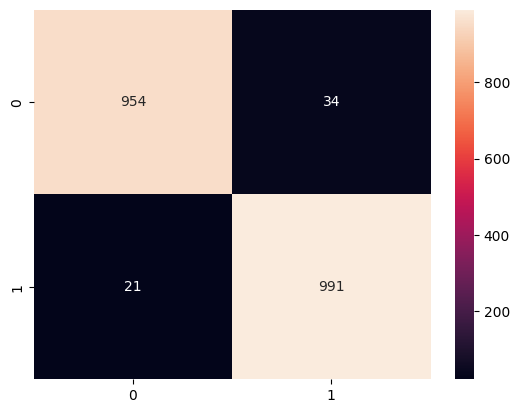

In [21]:
import seaborn as sns
sns.heatmap(c_matrix, annot=True, fmt='d');

In [88]:
# REVISAR NÚMEROS.

# Verdaderos Positivos (991): Son los casos en los que el modelo predijo correctamente que una URL es phishing (1)

# Falsos Positivos (34): Estos son los casos en los que el modelo predijo incorrectamente que una URL es phishing (1)
# cuando en realidad no lo es (0).

# Verdaderos Negativos (954): Son los casos en los que el modelo predijo correctamente que una URL no es phishing (0). 

# Falsos Negativos (21): Estos son los casos en los que el modelo predijo incorrectamente que una URL no es phishing (0) 
# cuando en realidad sí lo es (1). 

In [22]:
clf_rs = RandomizedSearchCV(estimator=pipe, param_distributions=search_space, cv=3, scoring="recall", verbose=2, n_jobs=-1)
clf_rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('selectkbest', SelectKBest()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions=[{'classifier': [LogisticRegression()],
                                         'classifier__C': [0.1, 1, 10],
                                         'scaler': [StandardScaler(), None],
                                         'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
                                        {'classifier': [Rando...
                                         'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
                                        {'classifier': [KNeighborsClassifier()],
                                         'classifier__n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                         'scaler': [StandardScaler(), None],
                                         'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
                                        {'classifier': [SVC()],
                                         'classifier__C': [0.1, 1, 10],
                                         'scaler': [StandardScaler(), None],
                                         'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}],
                   scoring='recall', verbose=2)

In [23]:
print(clf_rs.best_estimator_)
print(clf_rs.best_score_)
print(clf_rs.best_params_)

final_model = clf_rs.best_estimator_
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("recall_score", recall_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

Pipeline(steps=[('scaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=11)),
                ('classifier', RandomForestClassifier(max_depth=5))])
0.9676544634724508
{'selectkbest__k': 11, 'scaler': StandardScaler(), 'classifier__max_depth': 5, 'classifier': RandomForestClassifier()}
recall_score 0.967391304347826
confusion_matrix
 [[942  46]
 [ 33 979]]


In [24]:
print("recall_score", recall_score(y_test, y_pred))
c_matrix = confusion_matrix(y_test, y_pred)
print("matriz de confusion:")
print(c_matrix)

recall_score 0.967391304347826
matriz de confusion:
[[942  46]
 [ 33 979]]


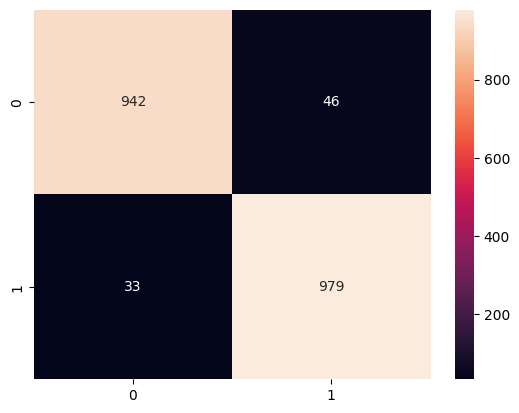

In [25]:
sns.heatmap(c_matrix, annot=True, fmt='d');

Aunque los falsos positivos hayan disminuido considerablemente, aumenta en 1 los falsos negativos (casos en los que el modelo predijo incorrectamente que una URL no es phishing, cuando en realidad sí lo es) por lo que me quedo con el modelo que me da
el GridSearchCV

In [26]:
results = cross_val_score(final_model, X, y, cv=5, scoring="recall")
print(results)
print(results.mean())
print(results.std())

[0.974 0.976 0.975 0.949 0.958]
0.9663999999999999
0.01092886087385141


In [92]:
# PIPELINE CON RANDOMFORESC Y GRADIENTBOOSTINGC (Y PCA)

In [27]:
pca = PCA(n_components=15)
X_pca = pca.fit(X)

In [28]:
pca.explained_variance_ratio_  

array([7.89197382e-01, 1.19247759e-01, 4.26867497e-02, 1.88642653e-02,
       1.08376221e-02, 4.24758304e-03, 3.46393983e-03, 2.39597584e-03,
       2.30523784e-03, 1.85237177e-03, 1.56147786e-03, 1.28675250e-03,
       1.17942600e-03, 8.35170391e-04, 3.82871059e-05])

Text(0, 0.5, 'Ratio de varianza acumulada')

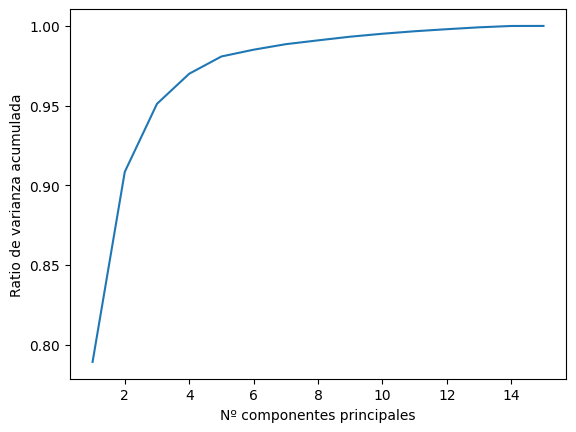

In [29]:
plt.plot(pd.Series(pca.explained_variance_ratio_.cumsum(), index=np.arange(1,16)))
plt.xlabel("Nº componentes principales")
plt.ylabel("Ratio de varianza acumulada")

In [32]:
pipe1 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=15)),
    ("classifier", RandomForestClassifier())
])
pipe1

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('classifier', RandomForestClassifier())])

In [33]:
pipe1.fit(X_train, y_train)                     

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('classifier', RandomForestClassifier())])

In [34]:
print("recall_score", recall_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

recall_score 0.967391304347826
confusion_matrix
 [[942  46]
 [ 33 979]]


In [35]:
pipe2 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=15)),
    ("classifier", GradientBoostingClassifier())
])
pipe2

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('classifier', GradientBoostingClassifier())])

In [36]:
pipe2.fit(X_train, y_train)  

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('classifier', GradientBoostingClassifier())])

In [37]:
print("recall_score", recall_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

recall_score 0.967391304347826
confusion_matrix
 [[942  46]
 [ 33 979]]


In [99]:
# INTENTO HACER MODELOS MÁS EXACTOS HIPERPARAMETRIZANDO:

In [100]:
# log_params = {
#     "scaler": [StandardScaler(), None],
#     "pca__n_components": [13, 14, 15],
#     "classifier__C": [0.1, 1, 10]
# }
# rf_params = {
#     "scaler": [StandardScaler(), None],
#     "pca__n_components": [13, 14, 15],
#     "classifier__max_depth": np.arange(2, 20),
#     "classifier__min_samples_leaf": [2, 3, 4]
# }
# gb_params = {
#     "scaler": [StandardScaler(), None],
#     "pca__n_components": [13, 14, 15],
#     "classifier__max_depth": np.arange(2, 20),
#     "classifier__min_samples_leaf": [2, 3, 4]
# }
# knn_params = {
#     "scaler": [StandardScaler(), None],
#     "pca__n_components": [13, 14, 15],
#     "classifier__n_neighbors": np.arange(2, 20)
# }
# svm_params = {
#     "scaler": [StandardScaler(), None],
#     "pca__n_components": [13, 14, 15],
#     "classifier__C": [0.1, 1, 10]
# }
# pipe1

In [101]:
# search_space = [
#     log_params,
#     rf_params,
#     gb_params,
#     knn_params,
#     svm_params   
# ]

In [102]:
# clf_rs1 = RandomizedSearchCV(pipe1, search_space, cv=5, scoring="recall", verbose=2, n_jobs=-1)

In [103]:
# clf_rs1.fit(X_train, y_train)        !! Aquí me da el error

In [104]:
# print(clf_rs.best_estimator_)
# print(clf_rs.best_score_)
# print(clf_rs.best_params_)

In [105]:
# final_model1 = clf_rs.best_estimator_
# final_model1.fit(X_train, y_train)
# y_pred = final_model1.predict(X_test)

In [106]:
# print("recall_score", recall_score(y_test, y_pred))                 
# print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

In [38]:
import pickle

In [39]:
with open(r'../models/modelo_01.pkl', "wb") as archivo_salida:
    pickle.dump(final_model, archivo_salida)

In [40]:
! pip install PyYAML


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import yaml

# Para leer el contenido del archivo YAML
with open(r"../models/model_config.yaml", "r") as archivo:
    datos_yaml = yaml.safe_load(archivo)

In [42]:
datos_yaml

{'model_name': 'modelo_01.',
 'selectkbest__k': 14,
 'scaler': 'None',
 'classifier__max_depth': 7,
 'classifier': 'GradientBoostingClassifier()'}